In [343]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, shape
from haversine import haversine, Unit
import pandas as pd
from shapely.geometry import MultiPoint, MultiPolygon
import json
import datetime
import pyarrow


In [344]:
import pandas as pd

kincaid = pd.read_csv('data/california_jul_nov_2019.csv', engine='pyarrow')
kincaid['date'] = pd.to_datetime(kincaid.date)

pre_fire = kincaid.query('date < "2019-10-23"')
during_fire = kincaid.query('date >= "2019-10-23" and date <= "2019-11-06"')

In [345]:
n_days = (during_fire.date.max() - during_fire.date.min()).days
during_fire = during_fire.groupby(['geoid_o', 'geoid_d']).agg({'visitor_flows':'sum', 'pop_flows':'sum'})
during_fire = during_fire.multiply(1/n_days)
during_fire.reset_index(inplace=True)

# add the latitudes and longtitudes
during_fire = during_fire.merge(kincaid.drop_duplicates(['geoid_o'])[['geoid_o','lat_o','lng_o']] ,how='left', on=['geoid_o']).merge(kincaid.drop_duplicates(['geoid_d'])[['geoid_d','lat_d','lng_d']], how='left', on='geoid_d')

during_fire

,geoid_o,geoid_d,visitor_flows,pop_flows,lat_o,lng_o,lat_d,lng_d
0,6001,6001,143944.000000,3.316598e+06,37.650547,-121.917885,37.650547,-121.917885
1,6001,6003,0.571429,1.257143e+01,37.650547,-121.917885,38.597251,-119.820653
2,6001,6005,28.785714,6.595000e+02,37.650547,-121.917885,38.446390,-120.651116
3,6001,6007,38.714286,8.890714e+02,37.650547,-121.917885,39.666929,-121.600672
4,6001,6009,36.214286,8.310000e+02,37.650547,-121.917885,38.204607,-120.554132
...,...,...,...,...,...,...,...,...
3008,6115,6107,3.357143,5.914286e+01,39.269008,-121.351263,36.220157,-118.800473
3009,6115,6109,0.285714,5.214286e+00,39.269008,-121.351263,38.027601,-119.954753
3010,6115,6111,2.285714,4.000000e+01,39.269008,-121.351263,34.357529,-119.126027
3011,6115,6113,128.214286,2.282143e+03,39.269008,-121.351263,38.686646,-121.901620


In [346]:
df_fire = pd.read_csv('data/ca_daily_fire_2000_03252022.csv')

In [347]:
df_fire = df_fire[df_fire['year']>= 2019]
df_fire = df_fire[df_fire['year']<= 2021]

In [348]:
df_fire

,latitude,longitude,acq_date,satellite,instrument,confidence,year,month
180,32.519249,-114.732300,2021-08-02,N,VIIRS,100,2021,8
184,32.521088,-114.731140,2021-08-02,N,VIIRS,50,2021,8
190,32.525978,-114.735359,2021-08-02,N,VIIRS,50,2021,8
211,32.533710,-114.799103,2020-02-29,N,VIIRS,50,2020,2
225,32.536598,-114.718857,2020-07-15,N,VIIRS,50,2020,7
...,...,...,...,...,...,...,...,...
1116850,41.999905,-123.618187,2020-09-19,N,VIIRS,50,2020,9
1116851,41.999920,-123.597160,2020-09-09,N,VIIRS,50,2020,9
1116852,41.999920,-123.407028,2020-09-10,N,VIIRS,50,2020,9
1116857,41.999950,-123.621155,2020-09-20,N,VIIRS,50,2020,9


In [349]:

# Define coordinates for the three wildfires
czu_lightning_complex_coords = (37.161, -122.208)
kincaid_fire_coords = (38.792458, -122.780053)
august_complex_coords = (39.765, -122.673)

# Define a threshold distance within which a record is considered to belong to a wildfire
threshold_distance = 2

# Compute distance to each wildfire and filter the records based on threshold distance
df_fire_czu = df_fire.copy()
df_fire_czu['dist_to_czu'] = df_fire_czu.apply(lambda row: haversine((row['latitude'], row['longitude']), czu_lightning_complex_coords), axis=1)
df_fire_czu = df_fire_czu[df_fire_czu['dist_to_czu'] <= threshold_distance]

df_fire_kincaid = df_fire.copy()
df_fire_kincaid['dist_to_kincaid'] = df_fire_kincaid.apply(lambda row: haversine((row['latitude'], row['longitude']), kincaid_fire_coords), axis=1)
df_fire_kincaid = df_fire_kincaid[df_fire_kincaid['dist_to_kincaid'] <= threshold_distance]

df_fire_august = df_fire.copy()
df_fire_august['dist_to_august'] = df_fire_august.apply(lambda row: haversine((row['latitude'], row['longitude']), august_complex_coords), axis=1)
df_fire_august = df_fire_august[df_fire_august['dist_to_august'] <= threshold_distance]



In [350]:
# Convert acq_date to datetime
df_fire_czu['acq_date'] = pd.to_datetime(df_fire_czu['acq_date'])

# Define the date range
start_date = pd.to_datetime('2020-08-16')
end_date = pd.to_datetime('2020-09-22')

# Filter df_fire_czu by date range
df_fire_czu = df_fire_czu[(df_fire_czu['acq_date'] >= start_date) & (df_fire_czu['acq_date'] <= end_date)]


In [351]:
df_fire_czu

,latitude,longitude,acq_date,satellite,instrument,confidence,year,month,dist_to_czu
298212,37.143261,-122.206825,2020-08-19,N,VIIRS,100,2020,8,1.975237
298349,37.144321,-122.212067,2020-08-19,N,VIIRS,50,2020,8,1.889323
298388,37.144577,-122.199677,2020-08-19,N,VIIRS,50,2020,8,1.969504
298500,37.145378,-122.217331,2020-08-19,N,VIIRS,50,2020,8,1.923888
298534,37.145706,-122.205154,2020-08-19,N,VIIRS,50,2020,8,1.719220
...,...,...,...,...,...,...,...,...,...
301941,37.176281,-122.218178,2020-08-19,N,VIIRS,50,2020,8,1.923670
301973,37.176548,-122.200005,2020-08-19,N,VIIRS,50,2020,8,1.868370
301986,37.176632,-122.210167,2020-08-20,N,VIIRS,50,2020,8,1.748775
302064,37.177322,-122.214470,2020-08-20,N,VIIRS,50,2020,8,1.903316


In [352]:
# Convert acq_date to datetime
df_fire_kincaid['acq_date'] = pd.to_datetime(df_fire_kincaid['acq_date'])

# Define the date range
start_date = pd.to_datetime('2019-10-23')
end_date = pd.to_datetime('2019-11-06')

# Filter df_fire_czu by date range
df_fire_kincaid = df_fire_kincaid[(df_fire_kincaid['acq_date'] >= start_date) & (df_fire_kincaid['acq_date'] <= end_date)]

In [353]:
df_fire_kincaid

,latitude,longitude,acq_date,satellite,instrument,confidence,year,month,dist_to_kincaid
518225,38.775566,-122.775024,2019-10-24,N,VIIRS,50,2019,10,1.928225
518247,38.775719,-122.780624,2019-10-24,N,VIIRS,50,2019,10,1.861952
518274,38.775879,-122.786545,2019-10-24,N,VIIRS,50,2019,10,1.927472
518379,38.776493,-122.775215,2019-10-24,N,VIIRS,50,2019,10,1.824086
518554,38.777489,-122.775085,2019-10-24,N,VIIRS,50,2019,10,1.719278
...,...,...,...,...,...,...,...,...,...
523032,38.808033,-122.789383,2019-10-25,N,VIIRS,50,2019,10,1.911297
523090,38.808350,-122.772789,2019-10-26,N,VIIRS,50,2019,10,1.875883
523147,38.808700,-122.778700,2019-10-26,Terra,MODIS,100,2019,10,1.809832
523167,38.808857,-122.787376,2019-10-25,N,VIIRS,100,2019,10,1.930756


In [354]:
df_fire_august

,latitude,longitude,acq_date,satellite,instrument,confidence,year,month,dist_to_august
643634,39.747101,-122.671097,2020-08-18,N,VIIRS,50,2020,8,1.996918
643640,39.747166,-122.675446,2020-08-18,N,VIIRS,100,2020,8,1.994046
643837,39.748280,-122.671112,2020-08-18,N,VIIRS,100,2020,8,1.866174
643887,39.748585,-122.676743,2020-08-18,N,VIIRS,100,2020,8,1.853099
643980,39.749092,-122.676956,2020-08-18,N,VIIRS,50,2020,8,1.800926
...,...,...,...,...,...,...,...,...,...
649653,39.781600,-122.677800,2020-08-22,Terra,MODIS,89,2020,8,1.890873
649698,39.781803,-122.667618,2020-08-20,N,VIIRS,50,2020,8,1.924194
649700,39.781807,-122.680550,2020-08-22,N,VIIRS,50,2020,8,1.977108
649745,39.782100,-122.678800,2020-08-22,Aqua,MODIS,54,2020,8,1.964983


In [355]:
df_fire_czu

,latitude,longitude,acq_date,satellite,instrument,confidence,year,month,dist_to_czu
298212,37.143261,-122.206825,2020-08-19,N,VIIRS,100,2020,8,1.975237
298349,37.144321,-122.212067,2020-08-19,N,VIIRS,50,2020,8,1.889323
298388,37.144577,-122.199677,2020-08-19,N,VIIRS,50,2020,8,1.969504
298500,37.145378,-122.217331,2020-08-19,N,VIIRS,50,2020,8,1.923888
298534,37.145706,-122.205154,2020-08-19,N,VIIRS,50,2020,8,1.719220
...,...,...,...,...,...,...,...,...,...
301941,37.176281,-122.218178,2020-08-19,N,VIIRS,50,2020,8,1.923670
301973,37.176548,-122.200005,2020-08-19,N,VIIRS,50,2020,8,1.868370
301986,37.176632,-122.210167,2020-08-20,N,VIIRS,50,2020,8,1.748775
302064,37.177322,-122.214470,2020-08-20,N,VIIRS,50,2020,8,1.903316


In [356]:
# Convert acq_date to datetime
df_fire_august['acq_date'] = pd.to_datetime(df_fire_august['acq_date'])

# Define the date range
start_date = pd.to_datetime('2020-08-16')
end_date = pd.to_datetime('2020-11-12')

# Filter df_fire_czu by date range
df_fire_august = df_fire_august[(df_fire_august['acq_date'] >= start_date) & (df_fire_august['acq_date'] <= end_date)]

In [357]:
df_fire_august

,latitude,longitude,acq_date,satellite,instrument,confidence,year,month,dist_to_august
643634,39.747101,-122.671097,2020-08-18,N,VIIRS,50,2020,8,1.996918
643640,39.747166,-122.675446,2020-08-18,N,VIIRS,100,2020,8,1.994046
643837,39.748280,-122.671112,2020-08-18,N,VIIRS,100,2020,8,1.866174
643887,39.748585,-122.676743,2020-08-18,N,VIIRS,100,2020,8,1.853099
643980,39.749092,-122.676956,2020-08-18,N,VIIRS,50,2020,8,1.800926
...,...,...,...,...,...,...,...,...,...
649653,39.781600,-122.677800,2020-08-22,Terra,MODIS,89,2020,8,1.890873
649698,39.781803,-122.667618,2020-08-20,N,VIIRS,50,2020,8,1.924194
649700,39.781807,-122.680550,2020-08-22,N,VIIRS,50,2020,8,1.977108
649745,39.782100,-122.678800,2020-08-22,Aqua,MODIS,54,2020,8,1.964983


In [358]:
def mark_blocked_paths(df_fire, df_travel, save_path, buffer_radius_km):

    # GeoDataFrame for travel data
    geometry_travel = [LineString([(row['lng_o'], row['lat_o']), (row['lng_d'], row['lat_d'])]) for idx, row in df_travel.iterrows()]
    gdf_travel = gpd.GeoDataFrame(df_travel, geometry=geometry_travel)

    # Set the CRS for the GeoDataFrames
    gdf_travel.set_crs("EPSG:4326", inplace=True)

    # For each unique date in the fire data, create a Polygon (buffered Convex Hull) that encompasses all points for that date
    df_fire['acq_date'] = pd.to_datetime(df_fire['acq_date'])
    unique_dates = df_fire['acq_date'].dt.date.unique()
    fire_polygons = []
    for date in unique_dates:
        df_date = df_fire[df_fire['acq_date'].dt.date == date]
        fire_points = MultiPoint([xy for xy in zip(df_date['longitude'], df_date['latitude'])])
        fire_polygon = gpd.GeoSeries(fire_points.convex_hull, crs="EPSG:4326")  # Create GeoSeries

        # Buffer the polygon
        # First, project the GeoDataFrame to a coordinate system where the unit is meters (e.g., UTM)
        fire_polygon_utm = fire_polygon.to_crs('EPSG:32610')  # Replace 'EPSG:32610' with the correct UTM zone if needed
        buffered_fire_polygon_utm = fire_polygon_utm.buffer(buffer_radius_km * 1000)  # Buffer the polygon in the projected coordinate system

        # Then, project the GeoDataFrame back to WGS84 (latitude/longitude coordinates)
        buffered_fire_polygon = buffered_fire_polygon_utm.to_crs('EPSG:4326')

        fire_polygons.append(buffered_fire_polygon.iloc[0])

    # GeoDataFrame for fire data
    gdf_fire = gpd.GeoDataFrame(df_fire['acq_date'].drop_duplicates().reset_index(drop=True), geometry=fire_polygons)
    gdf_fire.set_crs("EPSG:4326", inplace=True)

    # Save fire polygons as GeoJSON
    gdf_fire.to_file(save_path, driver="GeoJSON")

    print("Sample of gdf_travel before join:")
    print(gdf_travel.head())

    print("Sample of gdf_fire before join:")
    print(gdf_fire.head())

    join_result = gpd.sjoin(gdf_travel, gdf_fire, how="left", op="intersects")

    print("Sample of join_result after join:")
    print(join_result.head())

    blocked_paths = join_result[join_result.index_right.notnull()].index.unique()

    print("Sample of blocked_paths after join:")
    print(blocked_paths[:10])

    df_travel['blocked'] = False
    for path in blocked_paths:
        df_travel.loc[path, 'blocked'] = True

    print("Sample of df_travel after marking blocked paths:")
    print(df_travel.head())

    return df_travel, blocked_paths


In [359]:
buffer_radius_km = 10  # Specify your desired buffer radius here in kilometers.


In [360]:

# Apply function for each fire
# df_travel_czu_blocked, blocking_paths_czu = mark_blocked_paths(df_fire_czu, during_fire.copy(), "data/czu_fire_polygons.geojson")
df_travel_kincaid_blocked, blocking_paths_kincaid = mark_blocked_paths(df_fire_kincaid, during_fire.copy(), "data/kincaid_fire_polygons.geojson", buffer_radius_km)
# df_travel_august_blocked, blocking_paths_august = mark_blocked_paths(df_fire_august, during_fire.copy(), "data/august_fire_polygons.geojson")

Sample of gdf_travel before join:
   geoid_o  geoid_d  visitor_flows     pop_flows      lat_o       lng_o  \
0     6001     6001  143944.000000  3.316598e+06  37.650547 -121.917885   
1     6001     6003       0.571429  1.257143e+01  37.650547 -121.917885   
2     6001     6005      28.785714  6.595000e+02  37.650547 -121.917885   
3     6001     6007      38.714286  8.890714e+02  37.650547 -121.917885   
4     6001     6009      36.214286  8.310000e+02  37.650547 -121.917885   

       lat_d       lng_d                                           geometry  
0  37.650547 -121.917885  LINESTRING (-121.91789 37.65055, -121.91789 37...  
1  38.597251 -119.820653  LINESTRING (-121.91789 37.65055, -119.82065 38...  
2  38.446390 -120.651116  LINESTRING (-121.91789 37.65055, -120.65112 38...  
3  39.666929 -121.600672  LINESTRING (-121.91789 37.65055, -121.60067 39...  
4  38.204607 -120.554132  LINESTRING (-121.91789 37.65055, -120.55413 38...  
Sample of gdf_fire before join:
    acq_date   

/Users/luisquinonespr/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [361]:
df_travel_kincaid_blocked.blocked.nunique()

2

In [362]:
df_travel_kincaid_blocked.blocked.value_counts()

False    2937
True       76
Name: blocked, dtype: int64

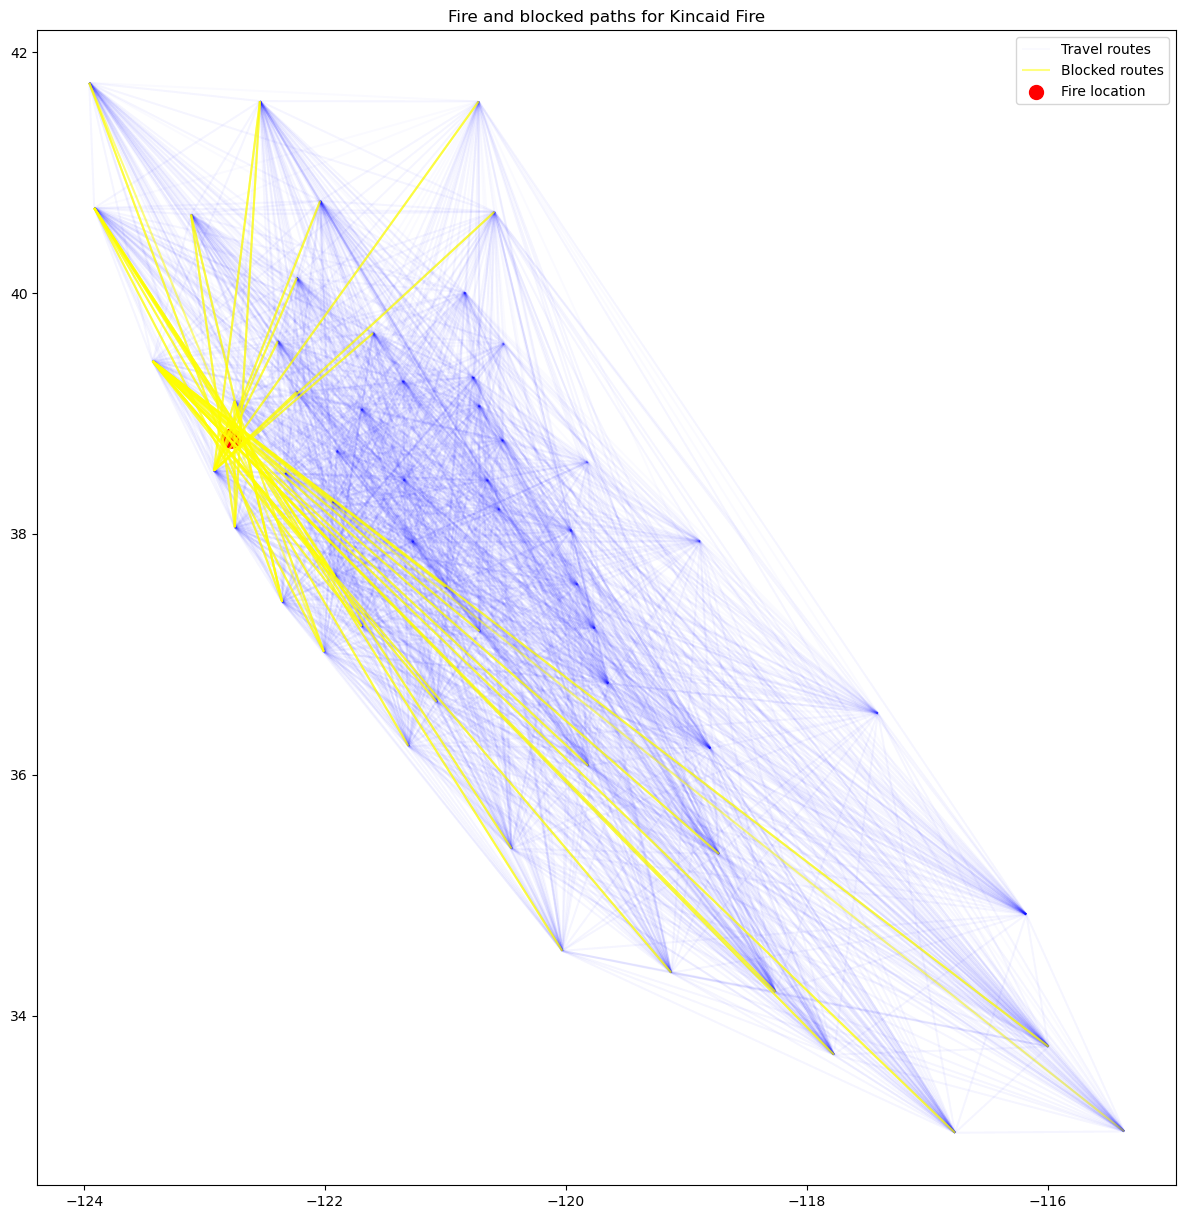

In [363]:
import json
import matplotlib.pyplot as plt

def plot_data(df_fire, df_travel, df_travel_blocked, fire_name):
    # Convert to GeoDataFrames
    geometry_fire = [Point(xy) for xy in zip(df_fire.longitude, df_fire.latitude)]
    gdf_fire = gpd.GeoDataFrame(df_fire, geometry=geometry_fire)

    geometry_travel = [LineString([(row['lng_o'], row['lat_o']), (row['lng_d'], row['lat_d'])]) for idx, row in df_travel.iterrows()]
    gdf_travel = gpd.GeoDataFrame(df_travel, geometry=geometry_travel)
    
    df_travel_blocked = df_travel_blocked[df_travel_blocked['blocked'] == True]
    gdf_travel_blocked = gpd.GeoDataFrame(df_travel_blocked, geometry=df_travel_blocked['geometry'])


    # Create plot
    fig, ax = plt.subplots(figsize=(15, 15))
    gdf_travel.plot(ax=ax, color='blue', label='Travel routes', alpha = 0.02)
    gdf_travel_blocked.plot(ax=ax, color='yellow', label='Blocked routes', alpha=0.5)
    gdf_fire.plot(ax=ax, color='red', markersize=100, label='Fire location', alpha=1.0)
    plt.title(f'Fire and blocked paths for {fire_name}')
    plt.legend()
    plt.show()


# Plot for each fire
# plot_data(df_fire_czu, df_travel, df_travel_czu_blocked, 'CZU Fire')
plot_data(df_fire_kincaid, during_fire, df_travel_kincaid_blocked, 'Kincaid Fire')
# plot_data(df_fire_august, df_travel, df_travel_august_blocked, 'August Fire')


In [364]:
with open('data/kincaid_fire_polygons.geojson', 'r') as file:
    geojson = json.load(file)

dates = []
areas = []

for feature in geojson['features']:
    # Extract the acquisition date and convert it to a datetime object
    date_str = feature['properties']['acq_date']
    date = datetime.datetime.strptime(date_str, '%Y-%m-%dT%H:%M:%S')
    dates.append(date)
    
    # Calculate the area of the polygon and convert it to square kilometers
    geom = shape(feature['geometry'])
    area = geom.area / 1_000_000  # Convert from square meters to square kilometers
    areas.append(area)


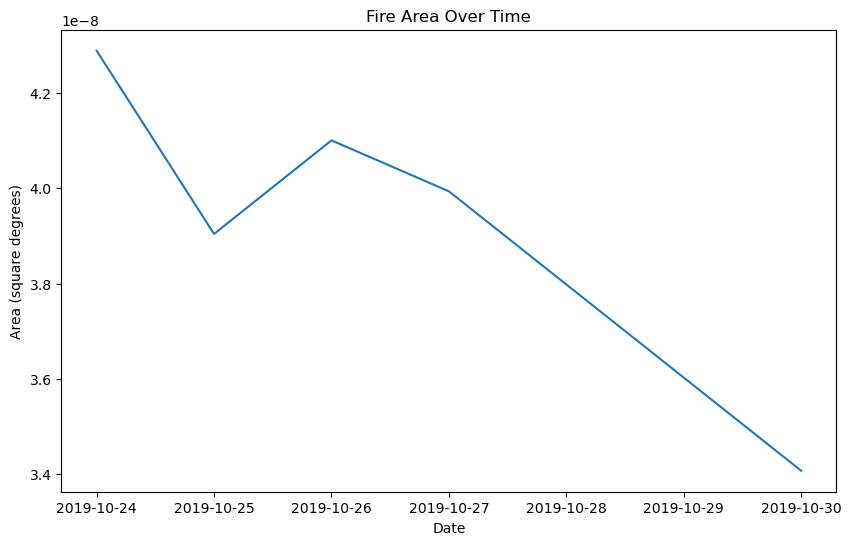

In [365]:
# Create a DataFrame
df = pd.DataFrame({'Date': dates, 'Area': areas})

# Sort the DataFrame by date
df.sort_values('Date', inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Area'])
plt.xlabel('Date')
plt.ylabel('Area (square degrees)')
plt.title('Fire Area Over Time')
plt.show()

In [366]:
# import networkx as nx

# # Construct a graph from the travel dataframe
# G = nx.from_pandas_edgelist(df_travel_august_blocked, 'lat_o', 'lat_d', create_using=nx.Graph())

# # Get blocked edges from the dataframe
# blocked_edges = df_travel_august_blocked[df_travel_august_blocked['blocked'] == True][['lat_o', 'lat_d']].values

# # Remove blocked edges from the graph
# G.remove_edges_from(blocked_edges)

# # Basic network plot
# nx.draw(G, with_labels=False, node_size=10)

# # Show plot
# plt.show()
